# Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

# Imports

In [1]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.utils import Bunch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import plotly_express as px
import plotly.graph_objects as go
import time
from IPython.display import Image

In [2]:
t_start_notebook = time.time()

In [3]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [4]:
df = pd.read_csv("./data/housing.csv")
display(df.head())
display(df.info())
df.dropna(inplace=True)
display(df.head())
display(df.info())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


None

# Drop Outliers

In [5]:
def sns_histplot(data: pd.DataFrame, x: str = ""):
    sns.histplot(
        data=data,
        x=x,
        kde=True,
        palette=sns.color_palette("bright")[:3],
    )

## House Values

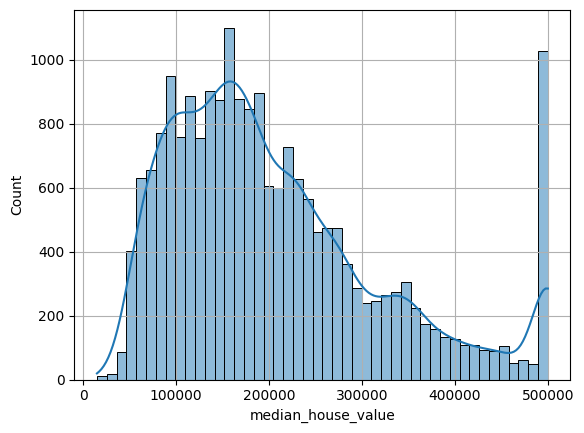

In [6]:
sns_histplot(df, x="median_house_value")

In [7]:
df = df.query("median_house_value < 500e3")

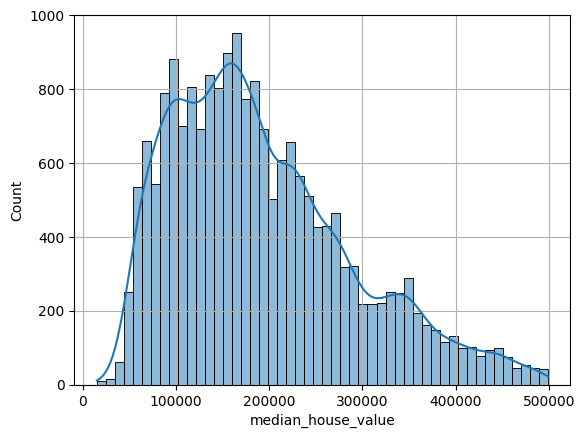

In [8]:
sns_histplot(df, x="median_house_value")

## Income

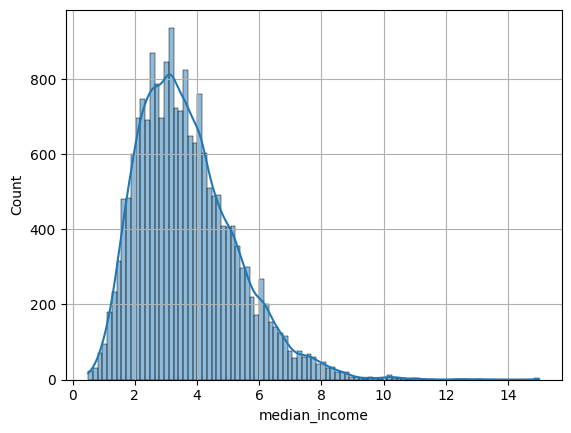

In [47]:
sns_histplot(df, x="median_income")

In [48]:
df = df.query("median_income < 9")

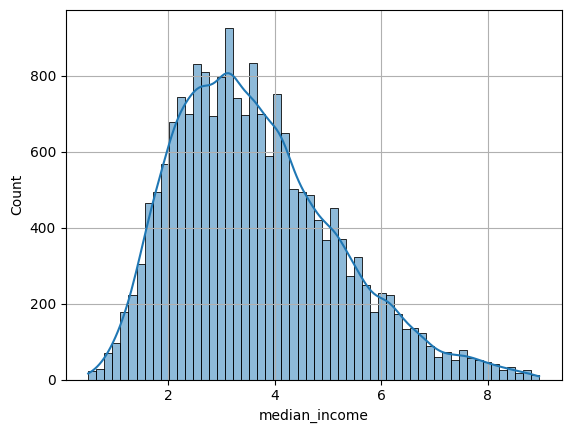

In [49]:
sns_histplot(df, x="median_income")

## Households

I noticed from the pairplots (since removed) that the houshold had a pretty long positive tail. I speculate this is the reason that the permutation importance was intermittently showing household as important, because depending on the split you might sample a weird part of that long tail in the train but not split, or vice versa. Remove the positive tail to hopefully reduce the oddity around this feature.

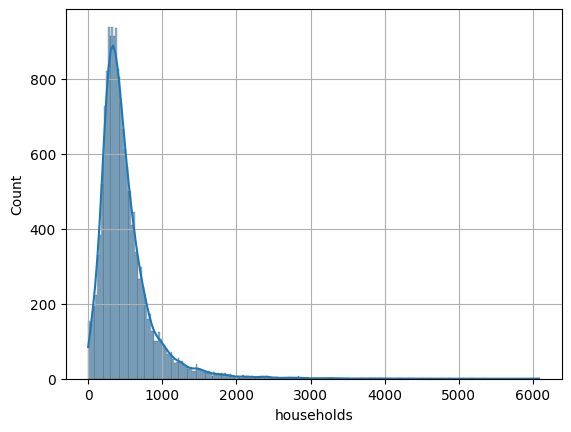

In [50]:
sns_histplot(df, x="households")

In [51]:
df = df.query("households < 1800")

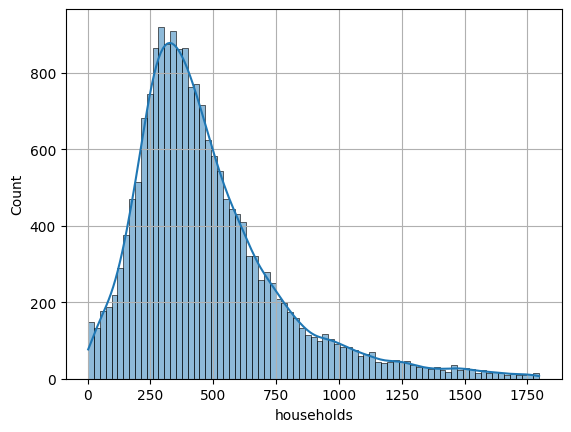

In [52]:
sns_histplot(df, x="households")

# What Correlates with House Value?

Income does

In [53]:
df.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.643452
total_rooms           0.168184
households            0.107747
total_bedrooms        0.081894
housing_median_age    0.078559
population            0.002616
longitude            -0.049117
latitude             -0.148272
Name: median_house_value, dtype: float64

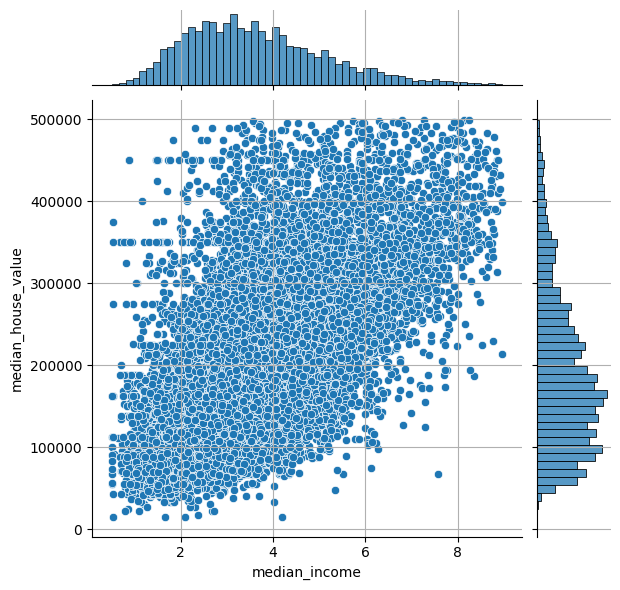

In [54]:
sns.jointplot(df, x="median_income", y="median_house_value")

# Feature Naming

In [55]:
all_features = df.columns.to_list()
target_feature = "median_house_value"
numeric_features = df.columns[df.dtypes != "object"].to_list()
numeric_features.remove(target_feature)
one_hot_features = ["ocean_proximity"]
print(
    "All Features = %s\nTarget Feature = %s\nNumeric Features = %s"
    % (all_features, target_feature, numeric_features)
)

All Features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']
Target Feature = median_house_value
Numeric Features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


# Scale the Data

In [56]:
df_fit = df.drop(columns=target_feature)
df_fit[numeric_features] = StandardScaler().fit_transform(df[numeric_features])
df_fit.head()
# df_fit.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-1.325064,1.029960,0.998679,-0.975790,-1.177920,-1.199206,-1.192836,3.096571,NEAR BAY
1,-1.320079,1.020670,-0.612695,2.850856,1.843797,1.190767,2.278165,3.080832,NEAR BAY
2,-1.330050,1.016025,1.884935,-0.614600,-0.989256,-0.999179,-1.017914,2.390406,NEAR BAY
3,-1.335035,1.016025,1.884935,-0.733356,-0.850078,-0.927905,-0.873861,1.322824,NEAR BAY
4,-1.335035,1.016025,1.884935,-0.516149,-0.710899,-0.919858,-0.736667,0.134485,NEAR BAY


# Split the Data

75% for training and 25% for development. No holdout set

In [57]:
(X_train, X_dev, y_train, y_dev) = train_test_split(
    df_fit,
    df[target_feature],
    random_state=42,
    train_size=0.75,
)

display([X_train.shape, X_dev.shape])

[(14329, 9), (4777, 9)]

# Model Builder

In [58]:
def build_model_pipeline(
    degree: int,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_dev: pd.DataFrame,
    y_dev: pd.Series,
    poly_features: list[str],
    one_hot_features: list[str],
) -> tuple[Pipeline, float, float]:
    xformer = make_column_transformer(
        (
            PolynomialFeatures(degree=degree, include_bias=False),
            poly_features,
        ),
        (
            OneHotEncoder(drop="if_binary"),
            one_hot_features,
        ),
    )

    model_features = poly_features + one_hot_features
    model = Pipeline(
        [
            ("transform", xformer),
            ("regression", LinearRegression(fit_intercept=True)),
        ]
    ).fit(X_train[model_features], y_train)

    rmse_train = root_mean_squared_error(
        y_train, model.predict(X_train[model_features])
    )
    rmse_dev = root_mean_squared_error(y_dev, model.predict(X_dev[model_features]))
    return (model, rmse_train, rmse_dev)

# Baseline Model

Linear in single feature

In [59]:
baseline_features = ["median_income"]
(baseline_model, rmse_train, rmse_dev) = build_model_pipeline(
    1, X_train, y_train, X_dev, y_dev, baseline_features, []
)

print("Train RMSE = $%.2f, Dev RMSE = $%.2f" % (rmse_train, rmse_dev))
baseline_model

Train RMSE = $73032.14, Dev RMSE = $76007.21


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['median_income']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  [])])),
                ('regression', LinearRegression())])

## Scatter plot of input data and fit

In [60]:
if 0:
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df[baseline_features[0]],
            y=df[target_feature],
            mode="markers",
            name="Input Data",
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df[baseline_features[0]],
            y=baseline_model.predict(df_fit[baseline_features]),
            mode="markers",
            name="Baseline Fit",
        )
    )

    # Image(fig.to_image(format="png", width=1200, height=400, scale=1))
    fig.show()

# Higher-Order Models

## Loop Over Polynomial Degree

Create models over a range of polynomial degrees, using all features

In [61]:
t_start_loop = time.time()
degrees = list(range(1, 6))
rmse_train_per_degree = []
rmse_dev_per_degree = []
models = []
poly_features = numeric_features.copy()
ohe_features = one_hot_features
# ohe_features = []  # can remove ocean proximity to save time, 2nd order analysis showed it was not important

for degree in degrees:
    (model, rmse_train_degree, rmse_dev_degree) = build_model_pipeline(
        degree,
        X_train,
        y_train,
        X_dev,
        y_dev,
        poly_features,
        ohe_features,
    )

    models.append(model)
    rmse_train_per_degree.append(rmse_train_degree)
    rmse_dev_per_degree.append(rmse_dev_degree)

    print(
        "Degree = %d, Train RMSE = $%.2f, Dev RMSE = $%.2f"
        % (degree, rmse_train_degree, rmse_dev_degree)
    )

print("\nRun time = %.2f seconds" % (time.time() - t_start_loop))

Degree = 1, Train RMSE = $58862.50, Dev RMSE = $60187.03
Degree = 2, Train RMSE = $53666.14, Dev RMSE = $55901.64


Degree = 3, Train RMSE = $51126.17, Dev RMSE = $55029.48
Degree = 4, Train RMSE = $47489.83, Dev RMSE = $54436.11
Degree = 5, Train RMSE = $43504.99, Dev RMSE = $376892.42

Run time = 3.79 seconds


## Plot of Error vs. Complexity

Text(0.5, 1.0, 'RMSE vs. Polynomial Degree')

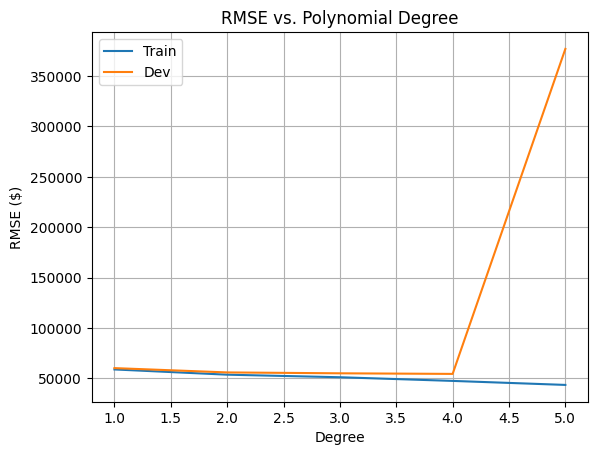

In [62]:
plt.plot(degrees, rmse_train_per_degree, label="Train")
plt.plot(degrees, rmse_dev_per_degree, label="Dev")
plt.xlabel("Degree")
plt.ylabel("RMSE ($)")
plt.legend()
plt.title("RMSE vs. Polynomial Degree")

# Permutation Importance

In [63]:
def get_permutation_importance(
    model, X: pd.DataFrame, y: pd.Series, **permutation_importance_kwargs
) -> Bunch:
    return permutation_importance(
        model,
        X,
        y,
        n_repeats=10,
        random_state=42,
        **permutation_importance_kwargs,
    )

In [64]:
def make_permutation_importance_DataFrame(
    pi: Bunch, features: list[str]
) -> pd.DataFrame:
    # Get a sorting by the mean importance, then build a frame with all the importances
    # where columns sorted from most important on down
    ordered_features = list(np.array(features)[np.argsort(pi.importances_mean)])[::-1]
    return pd.DataFrame(pi.importances.T, columns=features)[ordered_features]

In [65]:
def sns_barplot_permutation_importance(df: pd.DataFrame = None) -> None:
    sns.barplot(
        df,
        orient="h",
        err_kws={"color": "0.0"},
        capsize=0.5,
    )

    plt.xlabel("Permutation Importance")
    plt.ylabel("Feature")

## Of 1st Order Model

In [66]:
# Importance per feature - over development set
model_features = poly_features + ohe_features
df_pi_1 = make_permutation_importance_DataFrame(
    get_permutation_importance(models[0], X_dev[model_features], y_dev),
    model_features,
)

# df_pi_1

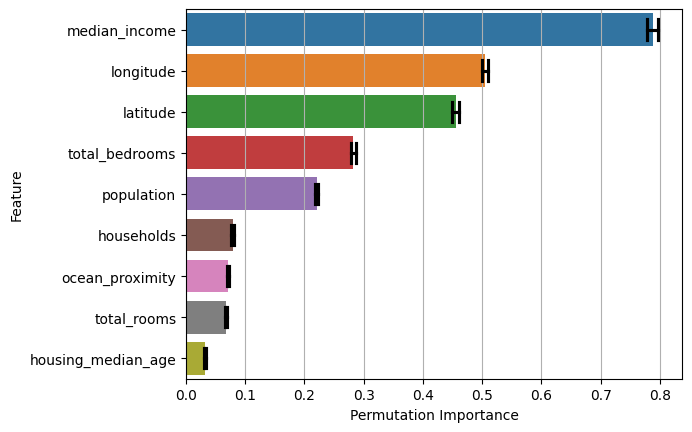

In [67]:
sns_barplot_permutation_importance(df=df_pi_1)

## Of 2nd Order Model

In [68]:
# Importance per feature - over development set
df_pi_2 = make_permutation_importance_DataFrame(
    get_permutation_importance(models[1], X_dev[model_features], y_dev),
    model_features,
)

# df_pi_2

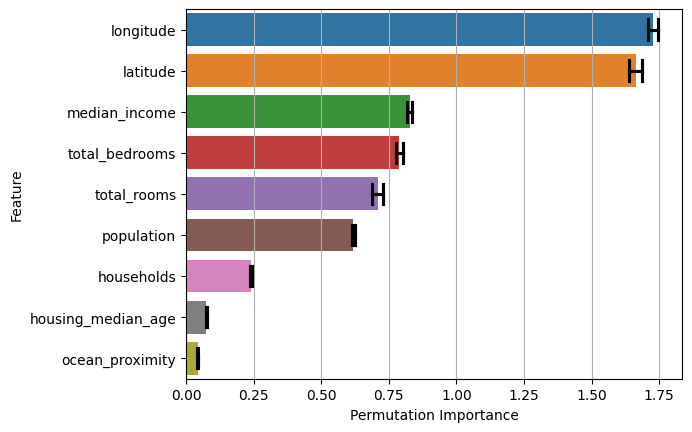

In [69]:
sns_barplot_permutation_importance(df=df_pi_2)

## Of 2nd Order Model, by Xformer Feature

### Get the Column-Transformed Features Names

In [70]:
xformed_names = [
    name.replace("polynomialfeatures__", "")
    .replace("onehotencoder__", "")
    .replace(" ", " x ")
    for name in models[1][0].get_feature_names_out()
]

# xformed_names

### Apply the Column Transformer to the Training and Dev Sets

In [71]:
X_train_xformed = pd.DataFrame(
    models[1][0].fit_transform(X_train[model_features]),
    columns=xformed_names,
)

X_dev_xformed = pd.DataFrame(
    models[1][0].fit_transform(X_dev[model_features]),
    columns=xformed_names,
)

X_train_xformed

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,longitude^2,longitude x latitude,longitude x housing_median_age,longitude x total_rooms,longitude x total_bedrooms,longitude x population,longitude x households,longitude x median_income,latitude^2,latitude x housing_median_age,latitude x total_rooms,latitude x total_bedrooms,latitude x population,latitude x households,latitude x median_income,housing_median_age^2,housing_median_age x total_rooms,housing_median_age x total_bedrooms,housing_median_age x population,housing_median_age x households,housing_median_age x median_income,total_rooms^2,total_rooms x total_bedrooms,total_rooms x population,total_rooms x households,total_rooms x median_income,total_bedrooms^2,total_bedrooms x population,total_bedrooms x households,total_bedrooms x median_income,population^2,population x households,population x median_income,households^2,households x median_income,median_income^2,ocean_proximity_<1H x OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR x BAY,ocean_proximity_NEAR x OCEAN
0,-1.335035,1.016025,1.884935,-0.951793,-0.918120,-1.094594,-0.963037,0.260534,1.782320,-1.356430,-2.516455,1.270677,1.225723,1.461322,1.285688,-0.347822,1.032307,1.915141,-0.967045,-0.932833,-1.112135,-0.978470,0.264709,3.552979,-1.794067,-1.730597,-2.063238,-1.815261,0.491089,0.905909,0.873860,1.041826,0.916611,-0.247974,0.842945,1.004969,0.884184,-0.239201,1.198136,1.054134,-0.285179,0.927440,-0.250904,0.067878,0.0,0.0,0.0,1.0,0.0
1,-1.454689,0.969576,1.482091,-0.200492,-0.262436,-0.299086,-0.249629,0.041370,2.116120,-1.410432,-2.155982,0.291654,0.381762,0.435077,0.363133,-0.060180,0.940078,1.437000,-0.194393,-0.254451,-0.289987,-0.242035,0.040111,2.196594,-0.297148,-0.388953,-0.443273,-0.369974,0.061314,0.040197,0.052616,0.059965,0.050049,-0.008294,0.068872,0.078491,0.065512,-0.010857,0.089452,0.074661,-0.012373,0.062315,-0.010327,0.001711,0.0,0.0,0.0,0.0,1.0
2,-1.295151,1.986813,0.273561,-0.070046,-0.101607,-0.056525,-0.091857,-0.934882,1.677416,-2.573222,-0.354303,0.090720,0.131597,0.073209,0.118968,1.210813,3.947424,0.543514,-0.139168,-0.201874,-0.112305,-0.182502,-1.857435,0.074836,-0.019162,-0.027796,-0.015463,-0.025128,-0.255747,0.004906,0.007117,0.003959,0.006434,0.065484,0.010324,0.005743,0.009333,0.094991,0.003195,0.005192,0.052844,0.008438,0.085875,0.874004,0.0,1.0,0.0,0.0,0.0
3,0.619304,-0.679369,1.159816,-0.088505,-0.284085,-0.297936,-0.139874,0.476325,0.383537,-0.420736,0.718279,-0.054812,-0.175935,-0.184513,-0.086625,0.294990,0.461542,-0.787943,0.060128,0.192999,0.202409,0.095026,-0.323600,1.345174,-0.102650,-0.329487,-0.345552,-0.162229,0.552450,0.007833,0.025143,0.026369,0.012380,-0.042157,0.080705,0.084639,0.039736,-0.135317,0.088766,0.041674,-0.141915,0.019565,-0.066626,0.226886,1.0,0.0,0.0,0.0,0.0
4,0.808755,-0.809426,0.273561,-0.495229,-0.611928,-0.188727,-0.589184,0.236197,0.654085,-0.654628,0.221244,-0.400519,-0.494900,-0.152634,-0.476505,0.191026,0.655171,-0.221427,0.400851,0.495311,0.152760,0.476901,-0.191184,0.074836,-0.135475,-0.167399,-0.051628,-0.161178,0.064614,0.245251,0.303044,0.093463,0.291781,-0.116972,0.374456,0.115487,0.360538,-0.144536,0.035618,0.111195,-0.044577,0.347138,-0.139163,0.055789,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14324,1.232527,-0.976643,-1.821225,-0.367858,-0.683064,-0.707186,-0.777825,0.489684,1.519124,-1.203740,-2.244710,-0.453395,-0.841895,-0.871627,-0.958691,0.603549,0.953832,1.778688,0.359266,0.667109,0.690669,0.759658,-0.478247,3.316862,0.669953,1.244013,1.287946,1.416595,-0.891825,0.135320,0.251271,0.260144,0.286129,-0.180134,0.466576,0.483053,0.531304,-0.334485,0.500112,0.550067,-0.346298,0.605012,-0.380889,0.239790,1.0,0.0,0.0,0.0,0.0
14325,-0.866393,1.382974,-0.773832,1.809743,1.014913,0.64586

### Importance per Composite Feature

In [72]:
# Importance per composite feature - over development set
df_pi_2_xformed = make_permutation_importance_DataFrame(
    get_permutation_importance(
        models[1][1],
        X_dev_xformed,
        y_dev,  # scoring="neg_root_mean_squared_error"
    ),
    xformed_names,
)

# df_pi_2_xformed

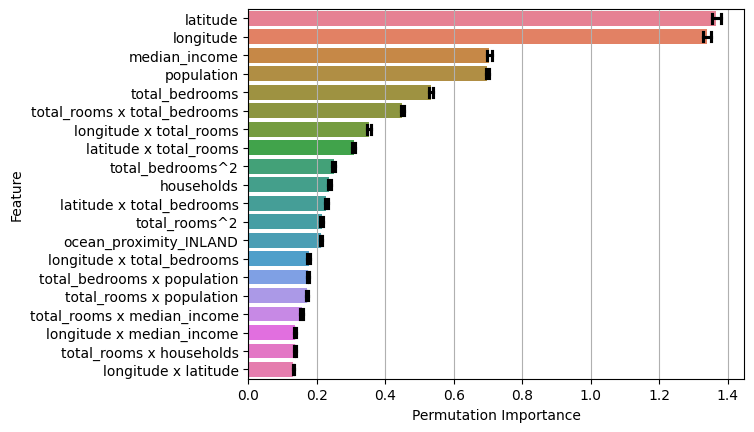

In [73]:
sns_barplot_permutation_importance(df=df_pi_2_xformed.iloc[:, :20])

### Compute Model Performance Using the Composite Features Directly

In [74]:
ordered_xformed_features = df_pi_2_xformed.columns
xformed_model = LinearRegression(fit_intercept=True).fit(
    X_train_xformed[ordered_xformed_features], y_train
)
rmse_train = root_mean_squared_error(
    y_train, xformed_model.predict(X_train_xformed[ordered_xformed_features])
)

# RMSE from composite feature should match that from pipelined process
print("Train RMSE = $%.2f, %.2f" % (rmse_train, rmse_train_per_degree[1]))

Train RMSE = $53666.14, 53666.14


# End of Notebook

In [75]:
# np.sqrt(5.0e09)
# 55e3**2 / 1e9

In [76]:
print("\nRun time = %.2f seconds" % (time.time() - t_start_notebook))


Run time = 13.61 seconds
